In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#create Spark session
spark = SparkSession.builder.appName('movieTags').getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [3]:
spark.sparkContext.uiWebUrl

'http://hub-msca-bdp-dphub-students-ridhi-m.c.msca-bdp-student-ap.internal:34503'

**1) Data Exploration**

***a. Read the movie synopsis data into Spark***

In [116]:
# reading movie synopsis data

df = spark.read.csv("gs://msca-bdp-student-gcs/movie_synopsis/mpst_full_data.csv",
                    header=True, inferSchema= True, sep=",", quote='"', escape='"', multiLine=True)

df.printSchema()

root
 |-- imdb_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- plot_synopsis: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- split: string (nullable = true)
 |-- synopsis_source: string (nullable = true)



In [26]:
df.show(5)

+---------+--------------------+--------------------+--------------------+-----+---------------+
|  imdb_id|               title|       plot_synopsis|                tags|split|synopsis_source|
+---------+--------------------+--------------------+--------------------+-----+---------------+
|tt0057603|I tre volti della...|Note: this synops...|cult, horror, got...|train|           imdb|
|tt1733125|Dungeons & Dragon...|Two thousand year...|            violence|train|           imdb|
|tt0033045|The Shop Around t...|Matuschek's, a gi...|            romantic| test|           imdb|
|tt0113862|  Mr. Holland's Opus|Glenn Holland, no...|inspiring, romant...|train|           imdb|
|tt0086250|            Scarface|In May 1980, a Cu...|cruelty, murder, ...|  val|           imdb|
+---------+--------------------+--------------------+--------------------+-----+---------------+
only showing top 5 rows



In [92]:
df.dropna(thresh=1,subset=('tags')).count()

14828

***b. Print basic summary statistics of the data set***


In [31]:
df.select(F.explode(F.split(F.col('tags'), ', '))).distinct().count()

71

***c. Create a horizontal bar chart of movie tag counts such as action, cult, horror, etc.***

In [85]:
ind_tag = df.select(F.explode(F.split(F.col('tags'), ', ')).alias('tags'))\
            .groupby('tags').count()\
            .sort('count')

In [86]:
tags_pd = ind_tag.toPandas()
tags_pd.head()

,tags,count
0,non fiction,37
1,christian film,42
2,autobiographical,44
3,magical realism,54
4,suicidal,54


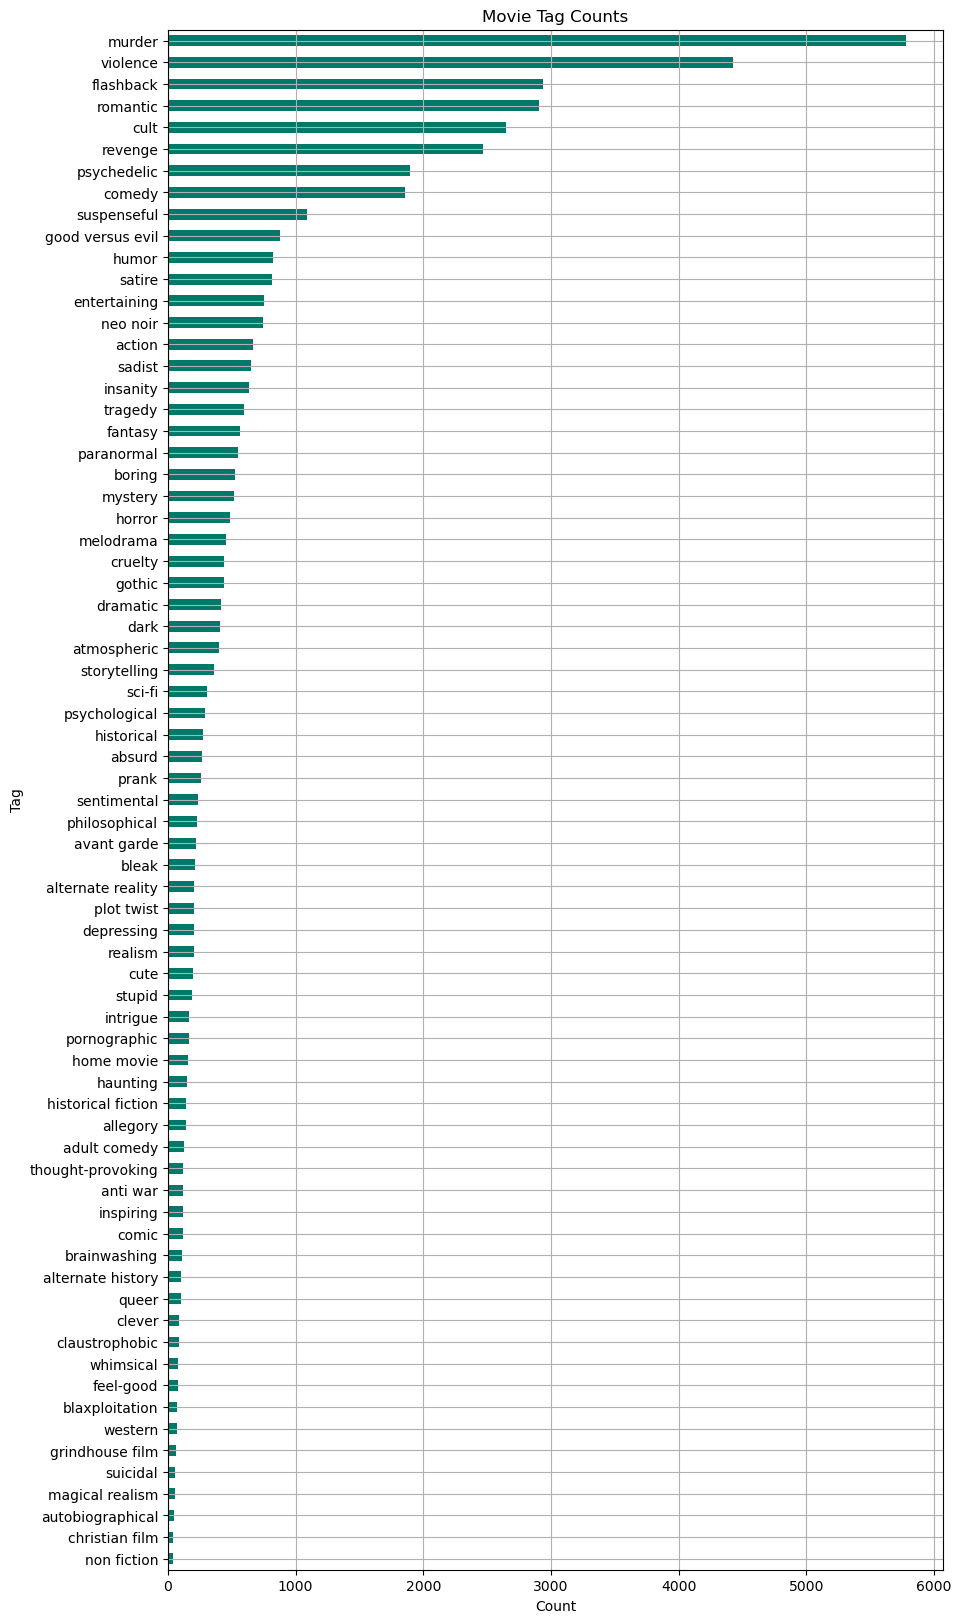

In [87]:
tags_pd.plot(figsize=(10, 20),kind='barh', y='count', x='tags', grid=True, legend=False, color='#00796B')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.title('Movie Tag Counts')
plt.show()


In [21]:
ind_tag.printSchema()

root
 |-- tags: string (nullable = true)
 |-- count: long (nullable = false)



***d. Arrange bar in descending order and identify the top 10 popular tags***

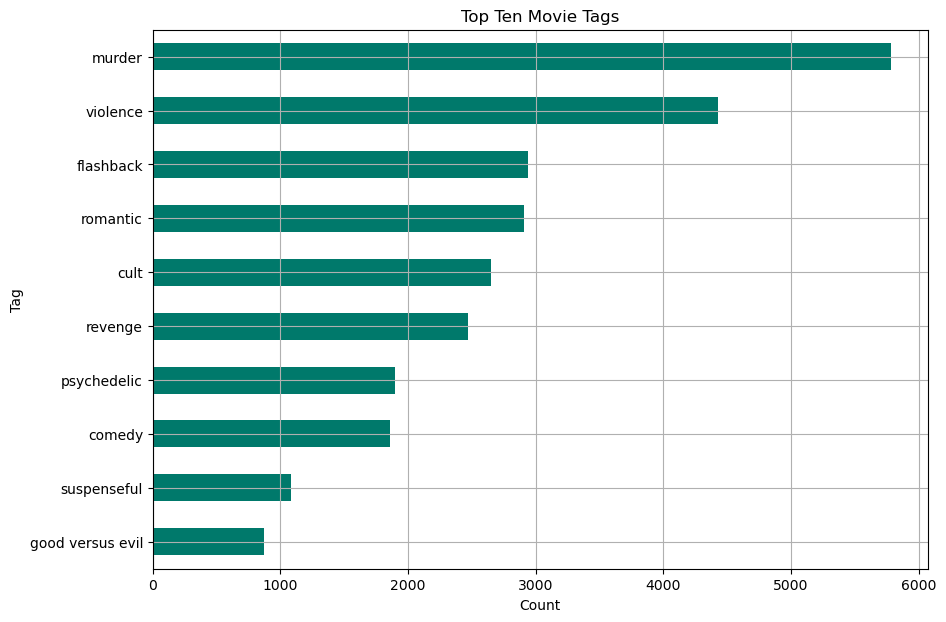

In [89]:
tags_pd.tail(10).plot(figsize=(10, 7),kind='barh', y='count', x='tags', grid=True, legend=False, color='#00796B')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.title('Top Ten Movie Tags')
plt.show()


In [111]:
top_tags = spark.createDataFrame(tags_pd.tail(10))
top_tags.show()

+----------------+-----+
|            tags|count|
+----------------+-----+
|good versus evil|  875|
|     suspenseful| 1086|
|          comedy| 1859|
|     psychedelic| 1897|
|         revenge| 2468|
|            cult| 2647|
|        romantic| 2906|
|       flashback| 2937|
|        violence| 4426|
|          murder| 5782|
+----------------+-----+



**2) Machine Learning Models**

***a. Use a SparkML pipeline to build models to classify movies into the top 10 most popular tags.***

In [152]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, RegexTokenizer
from pyspark.ml.classification import LogisticRegression

In [148]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import SentenceDetector, BertSentenceEmbeddings
from pyspark.ml import Pipeline

In [155]:
train = df.filter(F.col('split') == 'train').select('title', 'plot_synopsis', 'tags')

***b. The NLP pipeline should include removal of stopwords and tokenization of the syopsis data***


In [162]:
# tokenize synopsis data

tokenizer = RegexTokenizer(inputCol="plot_synopsis", outputCol="tokenized_plot", pattern="\s+|[\.,;:'\-!\?]+")

df_pr = tokenizer.transform(df).select('title', 'plot_synopsis','tokenized_plot', 'tags', 'split')

In [163]:
#remove stop words

remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="processed_plot")
df_pr = remover.transform(df_pr).drop("tokenized_plot")

In [141]:
df_pr.printSchema()
df_pr.select('plot_synopsis', 'processed_plot').show()

root
 |-- title: string (nullable = true)
 |-- plot_synopsis: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- split: string (nullable = true)
 |-- processed_plot: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+--------------------+
|       plot_synopsis|      processed_plot|
+--------------------+--------------------+
|Note: this synops...|[note, synopsis, ...|
|Two thousand year...|[two, thousand, y...|
|Matuschek's, a gi...|[matuschek, gift,...|
|Glenn Holland, no...|[glenn, holland, ...|
|In May 1980, a Cu...|[may, 1980, cuban...|
|George Falconer (...|[george, falconer...|
|Baise-moi tells t...|[baise, moi, tell...|
|Kyle Pratt (Jodie...|[kyle, pratt, (jo...|
|Small-time Italia...|[small, time, ita...|
|The movie begins ...|[movie, begins, v...|
|The action takes ...|[action, takes, p...|
|At the Somafree I...|[somafree, instit...|
|Brothers Terry (C...|[brothers, terry,...|
|Arrival.
A train ...|[arrival, train, ...

In [142]:
#df_pr.select(F.explode(F.col('processed_plot')).alias('word')).distinct().count()

178347

***c. The NLP pipeline should include more than one vectorization methods on the synopsis text for
comparison (e.g. Count Vectorization, HashingTF, TF-IDF, BERT, etc.)***

In [164]:
from pyspark.ml.feature import HashingTF, IDF, CountVectorizer

# implementing HashingTF
hashingTF = HashingTF(inputCol="processed_plot", outputCol="rawFeatures", numFeatures=2**18)
df_pr = hashingTF.transform(df_pr)

In [ ]:
# creating NLP pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF])


In [165]:
# implementing TF-IDF
idf = IDF(inputCol="rawFeatures", outputCol="tfidf_features")
idf_model = idf.fit(df_pr)  # Fit IDF on the data
df_features = idf_model.transform(df_pr)

***d. Pivot the data such that you are able to train one model for each genre tag.***


***e. The model should take in the movie synposis text as input features and individual tags as labels. Use the
existing column “split” to split the data into train and test.***

In [93]:
df.dropna().count()

14828